In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from tensorflow import keras
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout
from tensorflow.keras.models import Sequential
# Instead of importing from keras.utils.np_utils, use tensorflow.keras.utils directly
from tensorflow.keras.utils import to_categorical

In [6]:
!pwd

/content


In [19]:
# Load the dataset
raw_df = pd.read_csv('newsCorpora.csv', sep='\t', header=None, names=[
    'ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'
])


raw_df.head()

,ID,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
0,1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
1,2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
2,3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
3,4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
4,5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [20]:
# Select 5% of the data
raw_df = raw_df.sample(frac=0.05, random_state=42)  # random_state ensures reproducibility

# Reset index
raw_df = raw_df.reset_index(drop=True)

In [21]:
# Focus on essential columns: TITLE and CATEGORY.
df = raw_df[['TITLE','CATEGORY']]
df.head()

,TITLE,CATEGORY
0,Only 2 people allowed in the delivery room: Pr...,e
1,"A wealth of info, a welter of questions",b
2,Robin Thicke Naming Album After Paula Patton…,e
3,Actress And Civil Rights Activist Ruby Dee Die...,e
4,Feds to review Ga. Medicaid backlog,m


In [22]:
#shuffling rows with the help of sample, here (frac = 1) means return all rows
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,TITLE,CATEGORY
0,Credit Card Information At Risk After DMV Vend...,b
1,Justin Bieber Declares Selena Gomez 'My Baby' ...,e
2,"Joan Rivers Slams Lena Dunham Over ""Stay Fat"" ...",e
3,"Chris Brown, Lil Wayne, Tyga Performing ""Loyal...",e
4,"JPMorgan Chase Shareholders Back Directors, Ex...",b


<Axes: xlabel='CATEGORY', ylabel='count'>

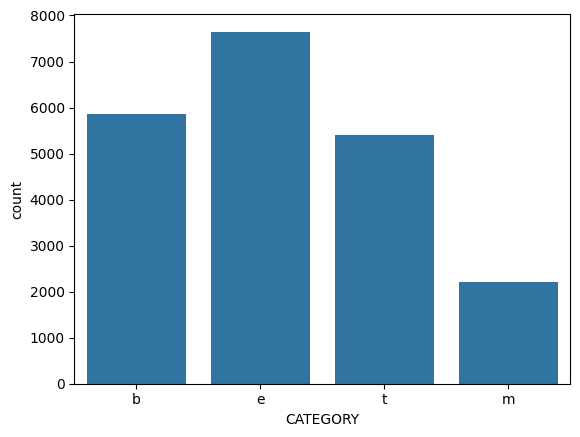

In [23]:
#plotting graph for categories
sns.countplot(x = 'CATEGORY',data = df)

In [24]:
#cleaning and preprocessing the text

import nltk
nltk.download('stopwords')

import re
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


cleaned = []
for i in range(0,len(df)):

    #removing any other words than (a-z) and (A-Z)
    msg = re.sub('[^a-zA-Z]',' ',df['TITLE'][i])

    #converting all texts to lower case
    msg = msg.lower()

    #tokenizing
    msg = msg.split()

    #stemming and removing stopwords
    ps = PorterStemmer()
    # Downloading stopwords resource if not already present

    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned.append(msg)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
cleaned[:5]

['credit card inform risk dmv vendor compromis',
 'justin bieber declar selena gomez babi surpris sxsw perform',
 'joan river slam lena dunham stay fat messag',
 'chri brown lil wayn tyga perform loyal bet award full video',
 'jpmorgan chase sharehold back director execut pay']

In [26]:
#taking dictionary size 5000
dict_size = 5000

#one hot encoding
one_hot_mat = [one_hot(words,dict_size) for words in cleaned]

#now for input as an embedding layer length of all rows should be equal therefore applying padding
#this will make size of all rows equal by adding 0 at starting of the shorter rows
#size of each row will be equal to length of longest row.
embedded_layer = pad_sequences(one_hot_mat,padding = 'pre',maxlen = 150)
embedded_layer

array([[   0,    0,    0, ..., 3228, 3571, 4098],
       [   0,    0,    0, ..., 2282, 2230, 4511],
       [   0,    0,    0, ..., 1172, 2459, 3239],
       ...,
       [   0,    0,    0, ..., 2069, 3658, 4287],
       [   0,    0,    0, ...,  217,  561, 1485],
       [   0,    0,    0, ..., 3639, 4874,   14]], dtype=int32)

In [28]:
#now creating independent and dependent features
x = embedded_layer
y = np.array(df['CATEGORY'])

In [29]:
#converting categorical values of y using OneHotEncoding
le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y,4)

In [30]:
y[:5]

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

In [31]:
#splitting the Dataset into Train and Test set
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(16896, 150) (16896, 4)
(4225, 150) (4225, 4)


In [32]:
#creating model using LSTM
model = Sequential()

#taking number features as 50
model.add(Embedding(dict_size,50,input_length = len(x[0])))
model.add(Dropout(0.2))

#adding LSTM layers with 100 neurons
model.add(LSTM(100))

#adding output layer
model.add(Dense(4,activation="softmax"))

#compiling the model
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

#summary of model
model.summary()

#training the model
rnn = model.fit(x_train, y_train, validation_data = (x_test,y_test), epochs = 10, batch_size = 256)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 46s 641ms/step - accuracy: 0.3700 - loss: 1.3066 - val_accuracy: 0.6265 - val_loss: 0.9482
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 659ms/step - accuracy: 0.7368 - loss: 0.7369 - val_accuracy: 0.8130 - val_loss: 0.5153
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 81s 647ms/step - accuracy: 0.8620 - loss: 0.4007 - val_accuracy: 0.8537 - val_loss: 0.4367
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 84s 676ms/step - accuracy: 0.9083 - loss: 0.2889 - val_accuracy: 0.8670 - val_loss: 0.3887
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 80s 648ms/step - accuracy: 0.9262 - loss: 0.2191 - val_accuracy: 0.8627 - val_loss: 0.3970
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 82s 643ms/step - accuracy: 0.9452 - loss: 0.1704 - val_accuracy: 0.8620 - val_loss: 0.4202
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 83s 665ms/step - accuracy: 0.9516 - loss: 0.1533 - val_accuracy: 0.8608 - val_loss: 0.4293
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 85s 708ms/step - accuracy: 0.9574 - loss: 0.1330 - val_accu

In [33]:
#evaluating our model
model.evaluate(x_test,y_test)

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8484 - loss: 0.5166


[0.5219603180885315, 0.8520709872245789]

In [34]:
#making predictions
pred = model.predict(x_test)

#saving index of maximum value of pred in preds (because in pred probabilities will come)
preds = []
for i in range(0,len(pred)):
    preds.append(pred[i].argmax())

#saving index of maximum value of y_test in actual
actual = []
for i in range(0,len(y_test)):
    actual.append(y_test[i].argmax())

133/133 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step


In [35]:
#classification report
from sklearn import metrics
report = metrics.classification_report(actual, preds, target_names = ['b','t','e','m'])
print(report)

              precision    recall  f1-score   support

           b       0.82      0.82      0.82      1190
           t       0.91      0.91      0.91      1516
           e       0.78      0.78      0.78       432
           m       0.83      0.84      0.84      1087

    accuracy                           0.85      4225
   macro avg       0.84      0.84      0.84      4225
weighted avg       0.85      0.85      0.85      4225



In [39]:
#checking category of a text
txt = ["having a good financial advisor, help your income to grow"]

#cleaning and preprocessing the text
cleaned = []
for i in range(0,len(txt)):
    msg = re.sub('[^a-zA-Z]',' ',txt[i])
    msg = msg.lower()
    msg = msg.split()
    ps = PorterStemmer()
    msg = [ps.stem(words) for words in msg if not words in set(stopwords.words('english'))]
    msg = ' '.join(msg)
    cleaned.append(msg)

#one hot encoding and embedding layer
one_hot_mat = [one_hot(words,dict_size) for words in cleaned]
embedded_layer = pad_sequences(one_hot_mat,padding = 'pre',maxlen = 150)
embedded_layer

#prediction
pred = model.predict(embedded_layer)
cat = ['Business','Science','Entertainment','Health']
print(pred, cat[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[[9.7600842e-01 1.3457717e-04 6.5306805e-05 2.3791654e-02]] Business
